### Research on Garch

In [23]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt 
import statsmodels.api as sm
from statsmodels.tsa.stattools import pacf, acf
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from arch import arch_model
from FactorPlotting import FactorPlotting
from tqdm import tqdm

In [ ]:
ticker_len = 10

In [29]:
pct_close = pd.read_parquet("db/tw/pdata/close_pct.parquet")
pct_close_w = pct_close.resample("W-FRI").sum()
indexes = pct_close_w.index
tickers = pct_close_w.columns[:ticker_len]
indices = indexes[52:]
forecast = np.zeros((len(indices), len(tickers)))
for index, date in enumerate(tqdm(indices, desc=f"arma model for top {ticker_len}, enumerate by da")):
    pct_train = pct_close_w.loc[indexes[index]:date]
    for i in range(ticker_len):
        series = pct_train[tickers[i]]
        if series.isna().any():
            prediction = 0
            print(tickers[i], "failed at", date)
            continue
            ###### ARIMA ma
        else:
            model = sm.tsa.arima.ARIMA(series, order=(2, 0, 0))
            model_fit = model.fit()
            prediction = model_fit.forecast(horizon=1).values[0]
        forecast[index, i] = prediction

arma model, enumerate by da: 100%|██████████| 78/78 [00:55<00:00,  1.41it/s]


In [52]:
outcome = pd.DataFrame(forecast, columns=tickers, index=indices)

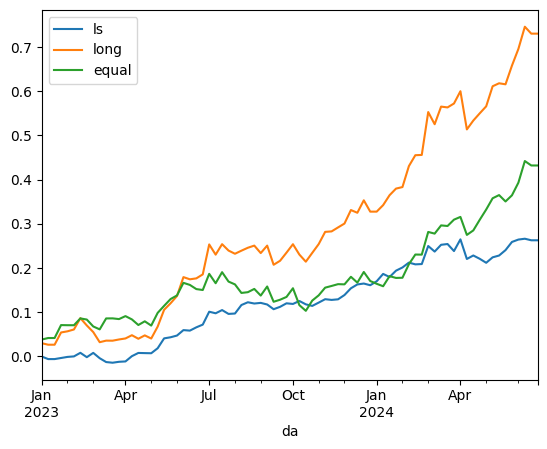

In [79]:
df1 = outcome.dropna(axis='columns', how='all').copy()
demean = df1.sub(df1.mean(axis=1), axis=0)
weighting = demean.div(demean.abs().sum(axis=1), axis=0)
long_only_weighting = weighting[weighting > 0].fillna(0.0)*2
row, col = weighting.shape
equal_weight_weighting = pd.DataFrame(np.ones((row, col))/col, columns=weighting.columns, index=weighting.index)
list_weighting = {'ls': weighting, 'long': long_only_weighting, "equal":equal_weight_weighting}
pct_corres = pct_close_w.loc[weighting.index[0]:].shift(-1)

for key, weight in list_weighting.items():
    list_weighting[key] = (1 + (pct_corres * weight).sum(axis=1)).cumprod()-1
df = pd.DataFrame(list_weighting)
df.plot(subplots=False, label=df.columns)
plt.show()